<h1>Reinforcement Learning</h1>

In [411]:
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import math
from collections import defaultdict
np.random.seed(0)

<h2>Q1</h2>
<h3>Reward1</h3>

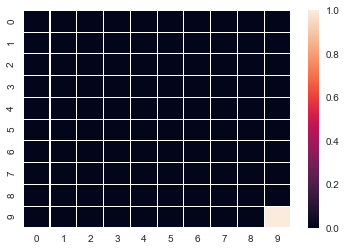

In [66]:
reward1 = np.zeros((10,10))
reward1[9,9] = 1
#cmap = ListedColormap(sns.color_palette("Blues"))
#cmap = sns.cm.rocket_r
sns.heatmap(reward1, linewidths=.1)

<h3>Reward2</h3>

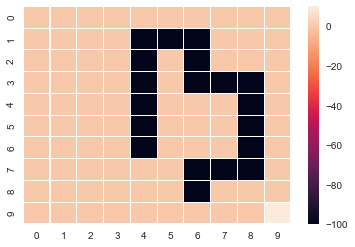

In [67]:
reward2 = np.zeros((10,10))
reward2[[i for i in range(1,7)] , 4] = -100
reward2[1,5] = -100
reward2[[i for i in range(1,4)] , 6] = -100
reward2[[i for i in range(7,9)] , 6] = -100
reward2[3,7] = -100
reward2[7,7] = -100
reward2[[i for i in range(3,8)] , 8] = -100
reward2[9,9] = 10
sns.heatmap(reward2, vmax=10, linewidths=.1)

<h3>State Space</h3>

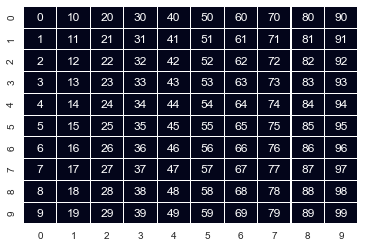

In [481]:
vals = np.arange(0,100)
state_vals = [vals[i:i+10] for i in range(0,100,10)]
state_space = np.array(state_vals).T
state_space
sns.heatmap(state_space, annot=True, fmt="d", linewidths=.1, vmax=0, cbar=False)

In [348]:
a = np.empty(10)
a.fill(-1)
modified_state_space = np.vstack((a, state_space, a))
b = np.empty((12,1))
b.fill(-1)
modified_state_space = np.hstack((b, modified_state_space, b))
modified_state_space

array([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
         -1.],
       [ -1.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,
         -1.],
       [ -1.,   1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91.,
         -1.],
       [ -1.,   2.,  12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92.,
         -1.],
       [ -1.,   3.,  13.,  23.,  33.,  43.,  53.,  63.,  73.,  83.,  93.,
         -1.],
       [ -1.,   4.,  14.,  24.,  34.,  44.,  54.,  64.,  74.,  84.,  94.,
         -1.],
       [ -1.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.,
         -1.],
       [ -1.,   6.,  16.,  26.,  36.,  46.,  56.,  66.,  76.,  86.,  96.,
         -1.],
       [ -1.,   7.,  17.,  27.,  37.,  47.,  57.,  67.,  77.,  87.,  97.,
         -1.],
       [ -1.,   8.,  18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98.,
         -1.],
       [ -1.,   9.,  19.,  29.,  39.,  49.,  59.,  69.,  79.,  89.,  99.,
         -1.],
       [ -1.,  -1.,  

In [103]:
actions = ["R", "L", "U", "D"]
actions

['R', 'L', 'U', 'D']

In [346]:
def neighbors(currentst, nextst):
    if nextst == currentst or nextst == currentst+1 or nextst == currentst-1 or nextst == currentst+10 or nextst == currentst-10:
        return True
    return False

In [347]:
def get_transition_probability(current_state, next_st,  r, c, action, w = 0.1, modified_state_space=modified_state_space):
    n = modified_state_space.shape[1]
    if action == "R":
        next_state = modified_state_space[r, c+1]
    if action =="L":
        next_state = modified_state_space[r, c-1]
    if action == "U":
        next_state = modified_state_space[r-1, c]
    if action == "D":
        next_state = modified_state_space[r+1, c]
   
    if next_st == -1 or not neighbors(current_state, next_st):
        # transition not possible
        return 0  
    if next_state == -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving off grid 
        if next_st == current_state:
            return (1-w+w/4+w/4)
        else:
            return (w/4)
    if next_state != -1 and (current_state ==0 or current_state==9 or current_state==90 or current_state==99):
        # corner states action moving on grid 
        if next_st == current_state:
            return (w/4+w/4)
        if next_state == next_st:
            return (1-w+w/4)
        else:
            return (w/4)
        
    if r == 1 or r == n-2 or c == 1 or c == n-2:
        # edge states
        if next_state == -1:
            # edge states action moving off grid
            if next_st == current_state:
                return (1-w+w/4)
            else:
                return (w/4)
        else:
            # edge states action moving on grid
            if next_st == next_state:
                return (1-w+w/4)
            else:
                return (w/4)
    else:
        # non boundary states
        if next_state == next_st:
            return (1-w+w/4)
        if neighbors(current_state, next_st):
            return (w/4)
        else:
            # action not possible
            return (0)
        

In [507]:
get_transition_probability(19, 19,  10, 2, "R", w = 0.1)

0.025

In [539]:
def get_neighbors(r, c, state_space=state_space):
    current_state = state_space[r,c]
    neighbor_list = [(r,c)]
    
    # corner states
    if current_state == 0:
        neighbor_list.extend([(r+1,c), (r,c+1)])
        return neighbor_list
    if current_state == 9:
        neighbor_list.extend([(r-1,c), (r,c+1)])
        return neighbor_list
    if current_state == 90:
        neighbor_list.extend([(r+1,c), (r,c-1)])
        return neighbor_list
    if current_state == 99:
        neighbor_list.extend([(r-1,c), (r,c-1)])
        return neighbor_list
    
    # edge states
    if r==0 and current_state!=0 and current_state!=90:
        neighbor_list.extend([(r,c+1), (r,c-1), (r+1,c)])
        return neighbor_list
    if r==9 and current_state!=9 and current_state!=99:
        neighbor_list.extend([(r,c+1), (r,c-1), (r-1,c)])
        return neighbor_list
    if c==0 and current_state!=0 and current_state!=9:
        neighbor_list.extend([(r,c+1), (r-1,c), (r+1,c)])
        return neighbor_list
    if c==9 and current_state!=90 and current_state!=99:
        neighbor_list.extend([(r,c-1),(r-1,c),(r+1,c)])
        return neighbor_list
    # other states
    else:
        neighbor_list.extend([(r+1,c),(r-1,c),(r,c+1),(r,c-1)]) 
        return neighbor_list

In [541]:
def get_estimation(s, reward, value, discount, modified_state_space=modified_state_space, action_set=actions):
    #print(s)
    actual_neighbors = get_neighbors(s[0]-1, s[1]-1)
    neighbor_states = [(i[0]+1, i[1]+1) for i in actual_neighbors]
    probs = defaultdict(list)
    action_map = {ac:actions.index(ac) for ac in action_set}
    estimations = np.zeros((len(action_set), len(neighbor_states)))
    #print(actual_neighbors)
    for ac in action_set:
        for ns in neighbor_states:
            probs[ac].append(get_transition_probability(modified_state_space[s], modified_state_space[ns],  s[0], s[1], ac))
     
    for ac in action_set:
        for n in range(len(actual_neighbors)):
            estimations[action_map[ac], n] = probs[ac][n] * (reward[actual_neighbors[n]]
                                                             + discount*value[actual_neighbors[n]])
            
    return estimations

In [535]:
def value_iteration(reward, state_space, action_set, w, discount, epsilon):
    n = len(state_space)
    states = [(i,j) for i in range(n) for j in range(n)]
    optimal_value = np.zeros((n,n))
    optimal_policy = np.zeros((n,n))
    delta = math.inf
    while delta > 0.01:
        delta = 0
        for s in states:
            v = optimal_value[s]
            action_estimations = get_estimation((s[0]+1,s[1]+1), reward, optimal_value, discount)
            optimal_value[s] = max(np.sum(action_estimations, axis=1))
            optimal_policy[s] = np.argmax(np.sum(action_estimations, axis=1))
            delta = max(delta, abs(v - optimal_value[s]))

    return optimal_value, optimal_policy

In [542]:
value1, policy1 = value_iteration(reward1, state_space, actions, 0.1, 0.8, 0.01)
print(value1)

[[ 0.07189374  0.10008523  0.13412175  0.17625482  0.228557    0.29355121
   0.37434918  0.47423445  0.5886492   0.63225388]
 [ 0.10008523  0.13621571  0.17914758  0.23236564  0.29849512  0.38073748
   0.48305592  0.60982794  0.75712433  0.81054131]
 [ 0.13412175  0.17914758  0.23242619  0.29857737  0.38084551  0.48322414
   0.61067226  0.76889019  0.95567897  1.04190862]
 [ 0.17625482  0.23236564  0.29857737  0.38084725  0.48322713  0.61069742
   0.76945595  0.96685398  1.20335073  1.33810508]
 [ 0.228557    0.29849512  0.38084551  0.48322713  0.61069776  0.76946964
   0.96728309  1.2135366   1.51245424  1.71739756]
 [ 0.29355121  0.38073748  0.48322414  0.61069742  0.76946964  0.96728906
   1.21381711  1.52097672  1.89802446  2.20332696]
 [ 0.37434918  0.48305592  0.61067226  0.76945595  0.96728309  1.21381711
   1.52110773  1.90418457  2.37867795  2.82616907]
 [ 0.47423445  0.60982794  0.76889019  0.96685398  1.2135366   1.52097672
   1.90418457  2.38188431  2.9774386   3.62487952]


<h2>Q2</h2>
<h3>Reward1 optimal values</h3>

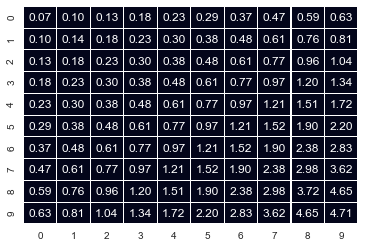

In [607]:
sns.heatmap(state_space, annot=value1, fmt='.2f', linewidths=.1, vmax=0, cbar=False)

<h2>Q3</h2>
<h3>Reward1 Heatmap</h3>

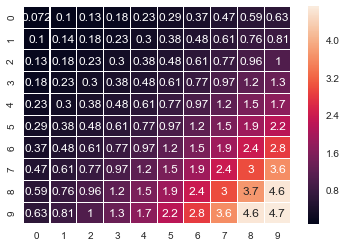

In [543]:
sns.heatmap(value1, annot=True, linewidths=.1)

In [544]:
print(policy1)

[[ 0.  3.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  3.  3.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  3.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [545]:
value2, policy2 = value_iteration(reward2, state_space, actions, 0.1, 0.8, 0.01)
print(value2)

[[  0.79003247   1.00357445   1.04834692   0.7088076   -2.29793052
   -4.36237264  -2.01480363   1.08616518   1.53876103   1.96491676]
 [  1.00817804   1.28943966   1.351662    -1.73871033  -9.44287348
  -11.62773752  -9.26849565  -1.41665871   1.8899169    2.51497936]
 [  1.27413368   1.62655031   1.7832325   -1.45343543  -9.42470714
  -14.61812456 -12.80460438  -5.87584039  -0.29310589   3.23375087]
 [  1.6050126    2.04615587   2.32953385  -1.01412378  -8.95250634
   -8.3004909  -10.84222555 -12.56647197  -4.74796162   4.2297672 ]
 [  2.01706009   2.56877668   3.01792219  -0.45894966  -8.40538392
   -3.29741789  -3.3065249   -7.74192501  -1.0150465    9.02816576]
 [  2.5301026    3.21956552   3.88546901   0.28735464  -7.6134253
   -0.43945047  -0.40242277  -3.0339976    3.98719801  15.25498933]
 [  3.16873543   4.02974027   4.97781543   3.41079823   0.17598914
    3.11017381  -0.34316629  -5.00378266  10.26373434  23.23643773]
 [  3.96323355   5.03806531   6.294477     7.75644662   

<h2>Q6</h2>
<h3>Reward2 optimal values</h3>

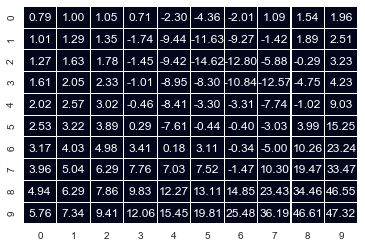

In [606]:
sns.heatmap(state_space, annot=value2, fmt='.2f', linewidths=.1, vmax=0, cbar=False)

<h2>Q7</h2>
<h3>Reward2 Heatmap</h3>

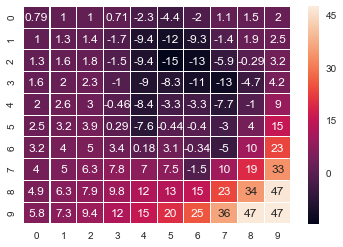

In [600]:
sns.heatmap(value2, annot=True, linewidths=.1)

In [547]:
print(policy2)

[[ 3.  3.  3.  1.  1.  0.  0.  0.  0.  3.]
 [ 0.  3.  3.  1.  1.  2.  0.  0.  0.  3.]
 [ 0.  3.  3.  1.  1.  3.  0.  0.  0.  3.]
 [ 0.  3.  3.  1.  1.  3.  3.  2.  0.  3.]
 [ 0.  3.  3.  1.  1.  3.  3.  3.  0.  3.]
 [ 0.  3.  3.  1.  1.  3.  3.  1.  0.  3.]
 [ 0.  3.  3.  3.  3.  3.  1.  1.  0.  3.]
 [ 0.  0.  3.  3.  3.  3.  1.  3.  3.  3.]
 [ 0.  0.  0.  0.  3.  3.  3.  3.  3.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [556]:
arrow_map = {0:'\u2192', 1:'\u2190', 2:'\u2191',3:'\u2193'}

In [581]:
def arrow_conversion(policy):
    policy_arrows = np.array(policy, dtype="object")
    for row in range(len(policy)):
        for col in range(len(policy)):
            idx = policy[row,col]
            policy_arrows[row,col] = arrow_map[idx]
    return policy_arrows

<h2>Q5</h2>
<h3>Reward1 optimal policy</h3>

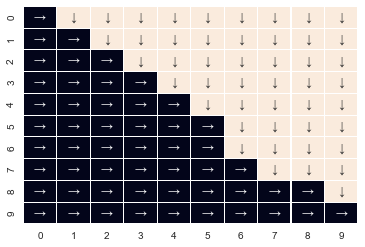

In [604]:
policy1_arrows = arrow_conversion(policy1)
sns.heatmap(policy1, annot=policy1_arrows, fmt='', linewidths=.1, cbar=False)

<h2>Q9</h2>
<h3>Reward2 optimal policy</h3>

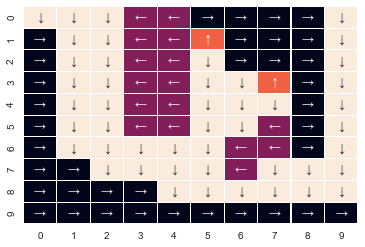

In [603]:
policy2_arrows = arrow_conversion(policy2)
sns.heatmap(policy2, annot=policy2_arrows, fmt='', linewidths=.1, cbar=False)

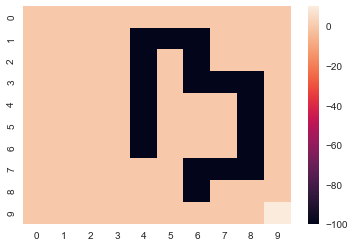

In [595]:
sns.heatmap(reward2)